# 

title: Water Rights Restored to the Gila River

subtitle: The impacts of irrigation on vegetation health in the Gila
River Valley

author:

-   Elsa Culler

-   Nate Quarderer

date: last-modified

image: /img/earth-analytics/water-rights/lesson-water-rights.png

image-alt: “Dry river with dead plants turns into a stream with living
plants”

description: \|

In 2004, the Akimel O’‘otham and Tohono O’’odham tribes won a water
rights settlement in the US Supreme Court. Using satellite imagery, we
can see the effects of irrigation water on the local vegetation.

learning-goals:

-   Open raster or image data using code

-   Combine raster data and vector data to crop images to an area of
    interest

-   Summarize raster values with stastics

-   Analyze a time-series of raster images

params:

id: stars

site_name: Gila River Indian Community

event: water rights case

data_dir: gila-river

jupyter:

kernelspec:

    name: learning-portal

    language: python

    display_name: Learning Portal

# STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [7]:
%store -r ndvi_ts boundary_gdf

You will also need to import any libraries you are using in this
notebook, since they won’t carry over from the previous notebook:

In [8]:
# Import libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd

import earthpy as et
import earthpy.plot as ep
from shapely.geometry import box

# STEP 4: Is the NDVI different within the **?meta:params.site_name** after the **?meta:params.event**?

You will compute the mean NDVI inside and outside the fire boundary.
First, use the code below to get a `GeoDataFrame` of the area outside
the Reservation.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Check the variable names - Make sure that the code uses your
boundary <code>GeoDataFrame</code></li>
<li>How could you test if the geometry was modified correctly? Add some
code to take a look at the results.</li>
</ol></div></div>

In [ ]:
from shapely.geometry import box, mapping

# Get NDVI raster bounding box
minx, miny, maxx, maxy = ndvi_ts.rio.bounds()

# Reproject boundary to match NDVI Coordinate system
boundary_gdf = boundary_gdf.to_crs(ndvi_ts.rio.crs)

# Full NDVI area as a GeoDataFrame
bbox = gpd.GeoDataFrame(
    {"geometry": [box(minx, miny, maxx, maxy)]},
    crs=ndvi_ts.rio.crs
)

# Area OUTSIDE the reservation
outside_gdf = gpd.overlay(bbox, boundary_gdf, how="difference")

Next, clip your DataArray to the boundaries for both inside and outside
the reservation. You will need to replace the `GeoDataFrame` name with
your own. Check out the [lesson on clipping data with the `rioxarray`
library in the
textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/).

> **GOTCHA ALERT**
>
> It’s important to use `from_disk=True` when clipping large arrays like
> this. It allows the computer to use less valuable memory resources
> when clipping - you will probably find that otherwise the cell below
> crashes your kernel.

In [11]:
# Clip data to both inside and outside the boundary
ndvi_inside = ndvi_ts.rio.clip(
    boundary_gdf.geometry.apply(mapping).tolist(),
    boundary_gdf.crs,
    from_disk=True
)
ndvi_outside = ndvi_ts.rio.clip(
    outside_gdf.geometry.apply(mapping).tolist(),
    outside_gdf.crs,
    from_disk=True
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>For <strong>both inside and outside</strong> the <span
data-__quarto_custom="true" data-__quarto_custom_type="Shortcode"
data-__quarto_custom_context="Inline"
data-__quarto_custom_id="3"></span> boundary:</p>
<ul>
<li>Group the data by year</li>
<li>Take the mean. You always need to tell reducing methods in
<code>xarray</code> what dimensions you want to reduce. When you want to
summarize data across <strong>all</strong> dimensions, you can use the
<code>...</code> syntax, e.g. <code>.mean(...)</code> as a
shorthand.</li>
<li>Select the NDVI variable</li>
<li>Convert to a DataFrame using the <code>to_dataframe()</code>
method</li>
<li>Join the two DataFrames for plotting using the <code>.join()</code>
method. You will need to rename the columns using the
<code>lsuffix=</code> and <code>rsuffix=</code> parameters</li>
</ul>
<p>Finally, plot annual July means for both inside and outside the
Reservation on the same plot.</p></div></div>

> **GOTCHA ALERT**
>
> The DateIndex in pandas is a little different from the Datetime
> Dimension in xarray. You will need to use the `.dt.year` syntax to
> access information about the year, not just `.year`.

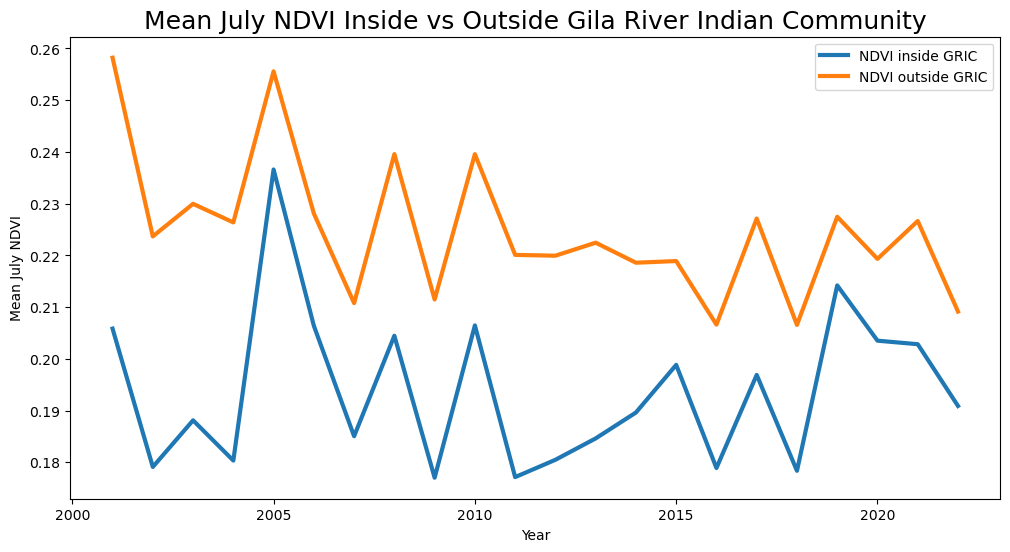

In [12]:
# Rasterize reservation boundary to create mask
mask_inside = ndvi_ts.rio.clip(
    boundary_gdf.geometry.apply(mapping).tolist(),
    boundary_gdf.crs,
    drop=False
)

inside_mask = ~np.isnan(mask_inside.NDVI)
outside_mask = (~inside_mask) & (~np.isnan(ndvi_ts.NDVI))

#  Select July data
july_mask = ndvi_ts['date'].dt.month == 7
ndvi_july = ndvi_ts.sel(date=july_mask)

ndvi_inside_july = ndvi_july.NDVI.where(inside_mask)
ndvi_outside_july = ndvi_july.NDVI.where(outside_mask)

# Spatial mean
inside_spatial_mean = ndvi_inside_july.mean(dim=("x","y"))
outside_spatial_mean = ndvi_outside_july.mean(dim=("x","y"))

# Group by year
inside_annual = inside_spatial_mean.groupby(ndvi_july['date'].dt.year).mean()
outside_annual = outside_spatial_mean.groupby(ndvi_july['date'].dt.year).mean()

# Overlapping columns
inside_annual = inside_annual.drop_vars(["band", "spatial_ref"], errors="ignore")
outside_annual = outside_annual.drop_vars(["band", "spatial_ref"], errors="ignore")

# Convert to DataFrames
inside_df = inside_annual.to_dataframe(name="NDVI_inside")
outside_df = outside_annual.to_dataframe(name="NDVI_outside")

# Join for plotting
ndvi_compare = inside_df.join(outside_df, how="inner")

# Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(ndvi_compare.index, ndvi_compare["NDVI_inside"], label="NDVI inside GRIC", linewidth=3)
ax.plot(ndvi_compare.index, ndvi_compare["NDVI_outside"], label="NDVI outside GRIC", linewidth=3)

ax.set_title("Mean July NDVI Inside vs Outside Gila River Indian Community", fontsize=18)
ax.set_xlabel("Year")
ax.set_ylabel("Mean July NDVI")
ax.legend()

plt.show()


Now, take the difference between outside and inside the site boundary
and plot that. What do you observe? Don’t forget to write a headline and
description of your plot!

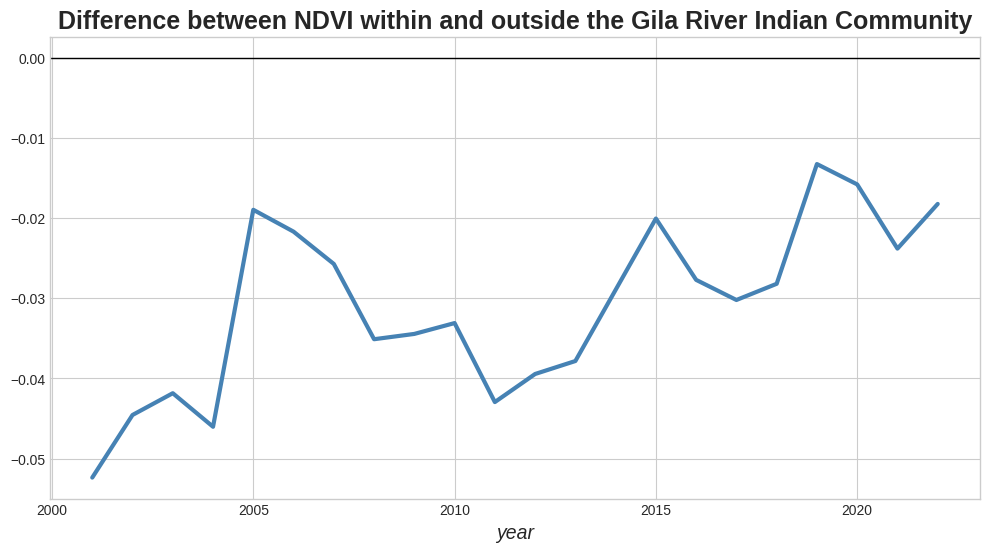

In [ ]:
# Compute NDVI difference inside - outside
ndvi_compare["NDVI_diff"] = ndvi_compare["NDVI_inside"] - ndvi_compare["NDVI_outside"]

# Plot difference inside − outside
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(
    ndvi_compare.index,
    ndvi_compare["NDVI_diff"],
    linewidth=3,
    color="steelblue"
)

# Title
ax.set_title(
    "Difference between NDVI within and outside the Gila River Indian Community",
    fontsize=18, weight="bold"
)

# Axis labels
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("", fontsize=14)

# Zero reference line
ax.axhline(0, color="black", linewidth=1)

plt.show()

YOUR HEADLINE AND DESCRIPTION HERE

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [ ]:
%store var1 var2

Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!